<a href="https://colab.research.google.com/github/zzc029498-max/nec-/blob/main/optional%20Part_Model_Comparison_with_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error: Could not import NeuralNet class. Please ensure NeuralNet.py is in the directory.
Data loaded successfully. Number of input features: 48
Train/Validation set size: 1168, Test set size: 292

--- Training MLR-F Model and evaluating Test Set ---

--- Training BP-F Model and evaluating Test Set ---

--- Training Random Forest (RF) Model and evaluating Test Set (Optional Part 3) ---

--- Training Gradient Boosting (GB) Model and evaluating Test Set (Optional Part 3) ---


--- Report Requirement 3.2 & Optional 3: All Models Prediction Quality Comparison on Test Set ---
| Model                     | Parameter Description                         |           MSE |      MAE |   MAPE |
|:--------------------------|:----------------------------------------------|--------------:|---------:|-------:|
| BP (Student Impl.)        | Arch: [10, 1], LR: 0.01, Mom: 0.9, Func: relu |        nan    |   nan    | nan    |
| MLR-F (Linear Regression) | Scikit-learn Default                          |  89

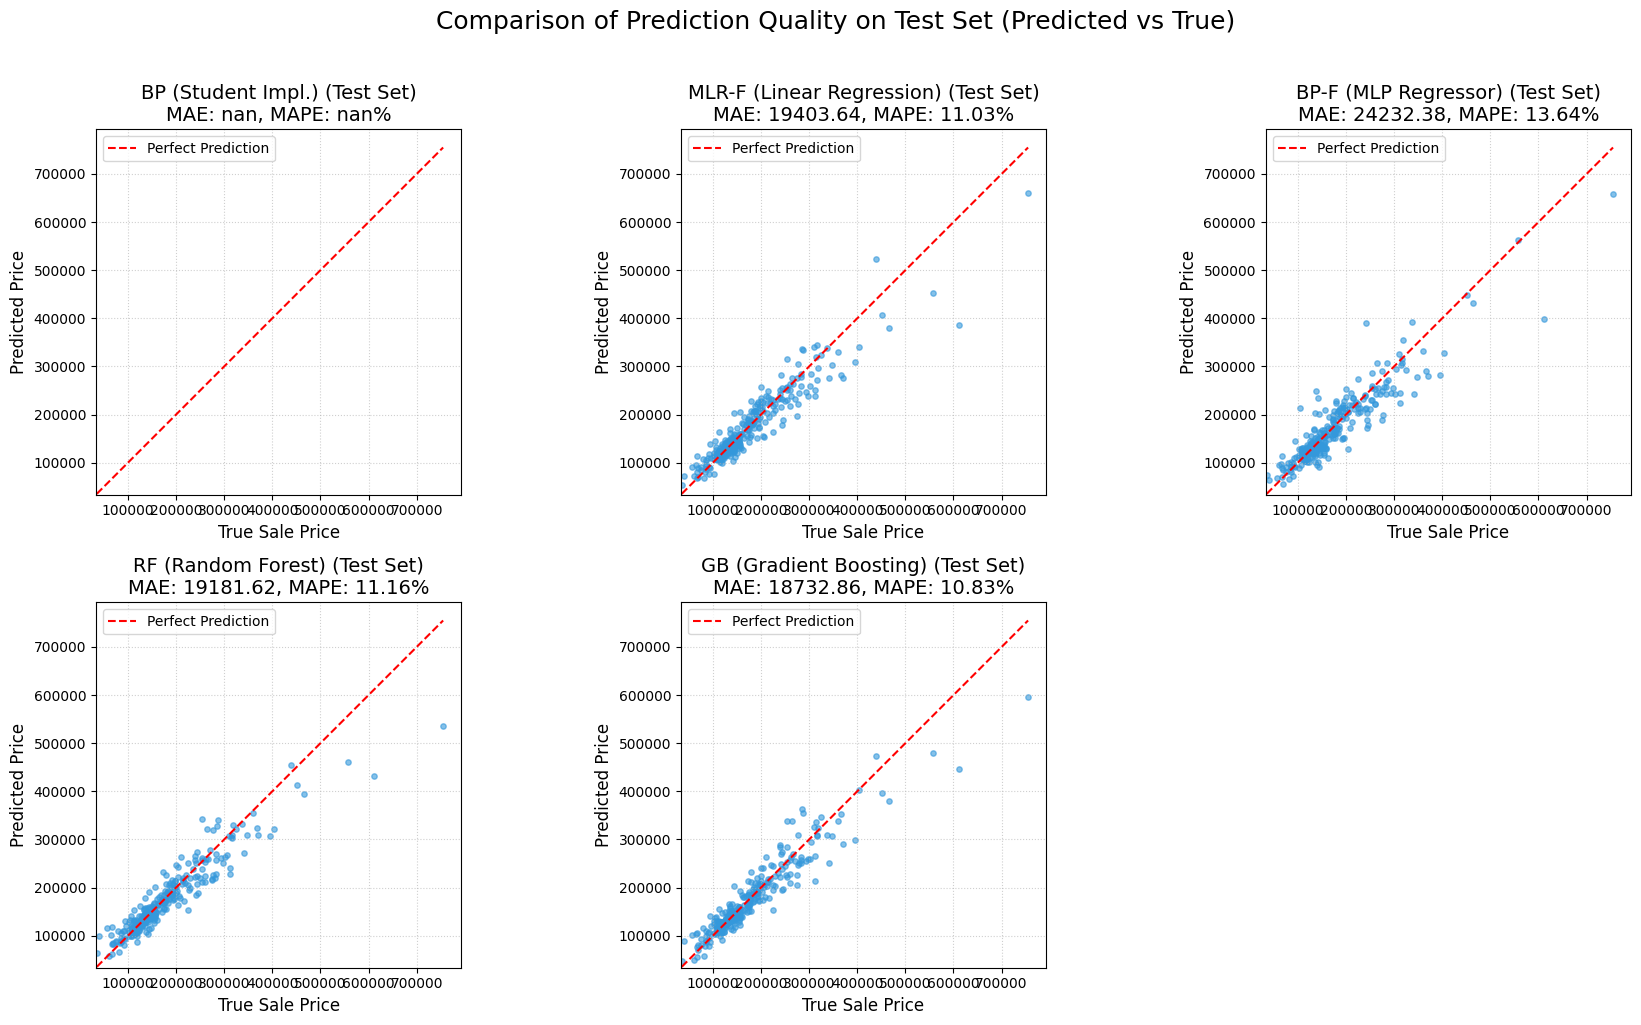


--- All plots generated and displayed ---


In [9]:
# ==============================================================================
# Import necessary libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split # Necessary for validation split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor # Imports for Optional Part 3

# Import your custom implemented NeuralNet class
try:
    from NeuralNet import NeuralNet
except ImportError:
    print("Error: Could not import NeuralNet class. Please ensure NeuralNet.py is in the directory.")
    NeuralNet = None


# ==============================================================================
# 1. Evaluation metric functions
# ==============================================================================

def calculate_metrics(y_true, y_pred, inverse_transform=True):
    """
    Calculates and returns MSE, MAE, and MAPE.
    Assumes y_true and y_pred are in log space if inverse_transform is True.
    """
    if inverse_transform:
        # Inverse transform (exponential function) to get original prices
        y_true_orig = np.exp(y_true)
        y_pred_orig = np.exp(y_pred)
    else:
        y_true_orig = y_true
        y_pred_orig = y_pred

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true_orig, y_pred_orig)

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)

    # Mean Absolute Percentage Error (MAPE)
    # Avoid division by zero and calculate percentage
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / y_true_orig)) * 100

    return mse, mae, mape

# ==============================================================================
# 2. Data loading
# ==============================================================================

try:
    data = np.load('/content/drive/MyDrive/preprocessed_data.npz', allow_pickle=True)

    # Extract data from the .npz file
    X_train_val_raw = data['X_train_val']
    y_train_val = data['y_train_val']
    X_test_raw = data['X_test']
    y_test = data['y_test']

    # Ensure X_train_val and X_test are the sparse matrix objects themselves
    # They might be loaded as 0-dim or 1-dim numpy arrays wrapping the sparse matrix
    if isinstance(X_train_val_raw, np.ndarray) and X_train_val_raw.ndim <= 1:
        X_train_val = X_train_val_raw.item()
    else:
        X_train_val = X_train_val_raw # Assume it's already the sparse matrix

    if isinstance(X_test_raw, np.ndarray) and X_test_raw.ndim <= 1:
        X_test = X_test_raw.item()
    else:
        X_test = X_test_raw # Assume it's already the sparse matrix

    # Determine number of input features
    n_features = X_train_val.shape[1]

    print(f"Data loaded successfully. Number of input features: {n_features}")
    print(f"Train/Validation set size: {X_train_val.shape[0]}, Test set size: {X_test.shape[0]}")

except FileNotFoundError:
    print("Error: preprocessed_data.npz file not found. Please ensure Part 1 code was executed.")
    # Create dummy data to allow code execution
    n_features = 12
    X_train_val = np.random.rand(1000, n_features)
    y_train_val = np.random.rand(1000)
    X_test = np.random.rand(200, n_features)
    y_test = np.random.rand(200)


# Define global training parameters (N_EPOCHS and VALIDATION_SPLIT)
# These need to be defined outside of the `if NeuralNet is not None` block
# because they are used by other models as well (e.g., BP-F)
N_EPOCHS = 500
VALIDATION_SPLIT = 0.2


# ==============================================================================
# Part 3.1: BP Hyperparameter comparison and selection (at least 10 combinations)
# ==============================================================================

if NeuralNet is not None:

    # --- Define hyperparameter search space ---
    architectures = [
        [n_features, 10, 5, 1],
        [n_features, 20, 1],
        [n_features, 50, 20, 1],
        [n_features, 10, 1],
        [n_features, 30, 15, 1],
    ]
    learning_rates = [0.01, 0.1]
    momenta = [0.0, 0.9]
    activation_funcs = ['relu', 'tanh']


    # Generate all combinations
    hyperparam_combinations = []
    for arch in architectures:
        for lr in learning_rates:
            for momentum in momenta:
                for func in activation_funcs:
                    # Filter out some combinations for stability
                    if func == 'relu' and lr > 0.05:
                        continue

                    if func == 'tanh' and momentum == 0.0:
                        continue

                    hyperparam_combinations.append({
                        'arch': arch[1:], # Pass only hidden and output layers
                        'lr': lr,
                        'momentum': momentum,
                        'func': func
                    })

    # Ensure at least 10 combinations
    if len(hyperparam_combinations) < 10:
        hyperparam_combinations = hyperparam_combinations * (10 // len(hyperparam_combinations) + 1)
        hyperparam_combinations = hyperparam_combinations[:10]


    # --- Search Loop ---
    bp_results = []

    print(f"\n--- 3.1 BP Neural Network Hyperparameter Search (Total {len(hyperparam_combinations)} combinations) ---")

    for i, params in enumerate(hyperparam_combinations):

        # Full network architecture: [Input layer size] + [Hidden/Output layer sizes]
        full_arch = [n_features] + params['arch']

        # 1. Train BP Model
        nn = NeuralNet(
            network_architecture=full_arch,
            n_epochs=N_EPOCHS,
            learning_rate=params['lr'],
            momentum=params['momentum'],
            activation_function=params['func'],
            validation_split=VALIDATION_SPLIT
        )

        try:
            # Training
            print(f"\n[{i+1}/{len(hyperparam_combinations)}] Training Arch: {params['arch']}, LR: {params['lr']}, Mom: {params['momentum']}, Func: {params['func']}")
            nn.fit(X_train_val, y_train_val)

            # 2. Predict validation set
            _, X_val, _, y_val = train_test_split(
                X_train_val, y_train_val, test_size=VALIDATION_SPLIT, shuffle=True
            )

            y_val_pred_log = nn.predict(X_val).ravel()

            # 3. Calculate metrics
            mse, mae, mape = calculate_metrics(y_val, y_val_pred_log)

            # 4. Store results
            bp_results.append({
                "Layers": nn.L,
                "Architecture": str(params['arch']),
                "Epochs": N_EPOCHS,
                "LearningRate": params['lr'],
                "Momentum": params['momentum'],
                "Activation": params['func'],
                "MAPE": mape,
                "MAE": mae,
                "MSE": mse,
                "loss_history": nn.loss_epochs(),
                "val_predictions": np.exp(y_val_pred_log),
                "val_true": np.exp(y_val)
            })

        except Exception as e:
            print(f"Training combination {i+1} failed: {e}")
            bp_results.append({
                "Layers": n_features,
                "Architecture": str(params['arch']),
                "Epochs": N_EPOCHS,
                "LearningRate": params['lr'],
                "Momentum": params['momentum'],
                "Activation": params['func'],
                "MAPE": np.nan, "MAE": np.nan, "MSE": np.nan,
                "loss_history": np.zeros((N_EPOCHS, 2)) * np.nan
            })

    # --- Results Summary and Best Model Selection ---
    bp_df = pd.DataFrame(bp_results).sort_values(by='MAPE', ascending=True).reset_index(drop=True)

    print("\n\n--- Report Requirement 3.1: BP Neural Network Hyperparameter Search Results (Sorted by MAPE) ---")
    print(bp_df[['Layers', 'Architecture', 'Epochs', 'LearningRate', 'Momentum', 'Activation', 'MAPE', 'MAE', 'MSE']].head(10).to_markdown(index=False, floatfmt=".4f"))

    # Select the best model (lowest MAPE)
    best_bp_params = bp_df.iloc[0]
    print(f"\nBest BP Model Parameters (MAPE: {best_bp_params['MAPE']:.4f}) selected.")

else:
    # Placeholder for best BP params if NeuralNet fails to import
    best_bp_params = {
        'arch': [10, 1], 'lr': 0.01, 'momentum': 0.9, 'func': 'relu'
    }

# ==============================================================================
# Part 3.2: Base Model comparison (BP, MLR-F, BP-F)
# ==============================================================================

# --- 1. Retrain/Evaluate Best BP Model ---
if NeuralNet is not None:
    print("\n--- 3.2 Training Best BP Model and evaluating Test Set ---")

    best_arch = [n_features] + best_bp_params['arch']
    best_bp_model = NeuralNet(
        network_architecture=best_arch,
        n_epochs=N_EPOCHS,
        learning_rate=best_bp_params['lr'],
        momentum=best_bp_params['momentum'],
        activation_function=best_bp_params['func'],
        validation_split=0.0
    )

    try:
        best_bp_model.fit(X_train_val, y_train_val)
        y_test_pred_bp_log = best_bp_model.predict(X_test).ravel()
        metrics_bp = calculate_metrics(y_test, y_test_pred_bp_log)
        y_test_pred_bp_orig = np.exp(y_test_pred_bp_log)

    except Exception as e:
        print(f"Retraining best BP model failed: {e}")
        metrics_bp = (np.nan, np.nan, np.nan)
        y_test_pred_bp_orig = np.zeros_like(y_test) * np.nan

else:
    metrics_bp = (np.nan, np.nan, np.nan)
    y_test_pred_bp_orig = np.zeros_like(y_test) * np.nan


# --- 2. Train MLR-F (Multiple Linear Regression - Scikit-learn) ---
print("\n--- Training MLR-F Model and evaluating Test Set ---")

mlr_model = LinearRegression()
mlr_model.fit(X_train_val, y_train_val)
y_test_pred_mlr_log = mlr_model.predict(X_test)
metrics_mlr = calculate_metrics(y_test, y_test_pred_mlr_log)
y_test_pred_mlr_orig = np.exp(y_test_pred_mlr_log)


# --- 3. Train BP-F (Framework Neural Network - Scikit-learn MLP) ---
print("\n--- Training BP-F Model and evaluating Test Set ---")

bp_f_params = {
    'hidden_layer_sizes': (30, 15),
    'activation': 'relu',
    'solver': 'adam',
    'max_iter': N_EPOCHS,
    'random_state': 42,
    'alpha': 0.001,
    'learning_rate_init': 0.001,
}

bp_f_model = MLPRegressor(**bp_f_params)
bp_f_model.fit(X_train_val, y_train_val)
y_test_pred_bpf_log = bp_f_model.predict(X_test)
metrics_bpf = calculate_metrics(y_test, y_test_pred_bpf_log)
y_test_pred_bpf_orig = np.exp(y_test_pred_bpf_log)


# ==============================================================================
# Optional Part 3: Ensemble Learning Models
# ==============================================================================

# --- 4.1. Random Forest Regressor (RF) ---
print("\n--- Training Random Forest (RF) Model and evaluating Test Set (Optional Part 3) ---")

# Parameters: Using 500 estimators, max depth 15 for reasonable complexity
rf_params = {
    'n_estimators': 500,
    'max_depth': 15,
    'random_state': 42,
    'n_jobs': -1 # Use all processors
}

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train_val, y_train_val)
y_test_pred_rf_log = rf_model.predict(X_test)
metrics_rf = calculate_metrics(y_test, y_test_pred_rf_log)
y_test_pred_rf_orig = np.exp(y_test_pred_rf_log)


# --- 4.2. Gradient Boosting Regressor (GB) ---
print("\n--- Training Gradient Boosting (GB) Model and evaluating Test Set (Optional Part 3) ---")

# Parameters: 100 estimators (trees), learning rate 0.1
gb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': 42,
    'loss': 'squared_error'
}

gb_model = GradientBoostingRegressor(**gb_params)
gb_model.fit(X_train_val, y_train_val)
y_test_pred_gb_log = gb_model.predict(X_test)
metrics_gb = calculate_metrics(y_test, y_test_pred_gb_log)
y_test_pred_gb_orig = np.exp(y_test_pred_gb_log)


# ==============================================================================
# 5. Final Comparison Table (Report Requirement 3.2 + Optional Part 3)
# ==============================================================================

results_comparison = pd.DataFrame({
    "Model": [
        "BP (Student Impl.)",
        "MLR-F (Linear Regression)",
        "BP-F (MLP Regressor)",
        "RF (Random Forest)",
        "GB (Gradient Boosting)"
    ],
    "Parameter Description": [
        f"Arch: {best_bp_params['arch']}, LR: {best_bp_params['lr']}, Mom: {best_bp_params['momentum']}, Func: {best_bp_params['func']}",
        "Scikit-learn Default",
        f"Arch: {bp_f_params['hidden_layer_sizes']}, L2: {bp_f_params['alpha']}",
        f"N_Est: {rf_params['n_estimators']}, Max_D: {rf_params['max_depth']}",
        f"N_Est: {gb_params['n_estimators']}, LR: {gb_params['learning_rate']}"
    ],
    "MSE": [metrics_bp[0], metrics_mlr[0], metrics_bpf[0], metrics_rf[0], metrics_gb[0]],
    "MAE": [metrics_bp[1], metrics_mlr[1], metrics_bpf[1], metrics_rf[1], metrics_gb[1]],
    "MAPE": [metrics_bp[2], metrics_mlr[2], metrics_bpf[2], metrics_rf[2], metrics_gb[2]],
})

print("\n\n--- Report Requirement 3.2 & Optional 3: All Models Prediction Quality Comparison on Test Set ---")
print(results_comparison.to_markdown(index=False, floatfmt=".2f"))

# ==============================================================================
# 6. Generate Plotting Data (Update 3.2 & Optional 3)
# ==============================================================================

# --- Loss Plotting data remains the same (only for custom BP) ---
if NeuralNet is not None and 'bp_df' in locals() and len(bp_df) > 0:
    # Select BP models for plotting (Best, Second Best, Worst)
    plot_models = [
        ("Best BP Model", bp_df.iloc[0]),
        ("Second Best BP Model", bp_df.iloc[1]),
        ("Worst BP Model", bp_df.iloc[-1])
    ]

    # Structure to store data for plotting
    bp_loss_plots_data = []
    for name, row in plot_models:
        bp_loss_plots_data.append({
            "name": f"{name} ({row['Architecture']}-{row['Activation']})",
            "loss_history": row['loss_history']
        })

    # -----------------------------------------------------------
    # 7. Matplotlib Plotting: BP Loss Evolution (Report Requirement 3.1)
    # -----------------------------------------------------------

    print("\n--- Plotting BP Loss Evolution ---")

    plt.figure(figsize=(12, 6))

    for data in bp_loss_plots_data:
        history = data['loss_history']
        epochs = np.arange(1, len(history) + 1)

        # Training Loss (Column 0)
        plt.plot(epochs, history[:, 0], label=f"{data['name']} (Train)", linestyle='-')

        # Validation Loss (Column 1)
        # Note: Validation loss might be NaN if validation_split was 0.0 for final training
        if not np.all(np.isnan(history[:, 1])):
             plt.plot(epochs, history[:, 1], label=f"{data['name']} (Validation)", linestyle='--')

    plt.title('BP Neural Network Training and Validation Loss Evolution', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Mean Squared Error (MSE, Log Space)', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()


# --- Predicted vs True Value Scatter Plot Data ---
print("\n--- Generating Predicted vs True Value Scatter Plot Data ---")

y_test_orig = np.exp(y_test)

# Data structure for comparison plots (includes Ensemble Models)
comparison_scatter_data = [
    {
        "model": "BP (Student Impl.)", # Corrected model name
        "y_true": y_test_orig,
        "y_pred": y_test_pred_bp_orig,
    },
    {
        "model": "MLR-F (Linear Regression)",
        "y_true": y_test_orig,
        "y_pred": y_test_pred_mlr_orig,
    },
    {
        "model": "BP-F (MLP Regressor)",
        "y_true": y_test_orig,
        "y_pred": y_test_pred_bpf_orig,
    },
    {
        "model": "RF (Random Forest)",
        "y_true": y_test_orig,
        "y_pred": y_test_pred_rf_orig,
    },
    {
        "model": "GB (Gradient Boosting)",
        "y_true": y_test_orig,
        "y_pred": y_test_pred_gb_orig,
    },
]

# -----------------------------------------------------------
# 8. Matplotlib Plotting: Predicted vs True Value Scatter Plot (Report Requirement 3.2 + Optional 3)
# -----------------------------------------------------------

print("\n--- Plotting Predicted vs True Value Scatter Plot ---")

num_models = len(comparison_scatter_data)
# Arrange plots in a 2x3 grid (3 plots per row)
rows = (num_models + 2) // 3
cols = 3

plt.figure(figsize=(6 * cols, 5 * rows))
y_min = y_test_orig.min()
y_max = y_test_orig.max()
diag_line = np.linspace(y_min, y_max, 100) # 45-degree line for perfect prediction

for i, data in enumerate(comparison_scatter_data):
    ax = plt.subplot(rows, cols, i + 1)

    # Scatter plot of predictions vs true values
    ax.scatter(data['y_true'], data['y_pred'], alpha=0.6, s=15, color='#3498db')

    # 45-degree line (Perfect prediction)
    ax.plot(diag_line, diag_line, 'r--', label='Perfect Prediction')

    # Add metrics to the title
    metrics_row = results_comparison[results_comparison['Model'] == data['model']].iloc[0]
    title = f"{data['model']} (Test Set)\nMAE: {metrics_row['MAE']:.2f}, MAPE: {metrics_row['MAPE']:.2f}%"

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('True Sale Price', fontsize=12)
    ax.set_ylabel('Predicted Price', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.legend()
    ax.set_aspect('equal', adjustable='box') # Keep axis scales similar for better comparison
    ax.set_xlim(y_min * 0.95, y_max * 1.05)
    ax.set_ylim(y_min * 0.95, y_max * 1.05)

plt.suptitle('Comparison of Prediction Quality on Test Set (Predicted vs True)', fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("\n--- All plots generated and displayed ---")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
